In [8]:
using SparseArrays, PyPlot, LinearAlgebra

In [9]:
function euler_fluxes(r, ru, rv, rE)
    g = 7/5
    p = @. (g - 1) * r * (rE / r - (ru^2 + rv^2)/(2*r^2))
    Frx = ru
    Fry = rv
    Frux = @. ru^2 / r + p
    Fruy = @. ru * rv / r 
    Frvx = @. ru * rv / r 
    Frvy = @. rv^2 / r + p
    FrEx = @. ru * (rE + p) / r
    FrEy = @. rv * (rE + p) / r

    Frx, Fry, Frux, Fruy, Frvx, Frvy, FrEx, FrEy
end

euler_fluxes (generic function with 1 method)

In [118]:
function compact_div(Fx, Fy, h)
    m = trunc(Int64, 1/h - 1)
    LHS = SymTridiagonal(4*ones(m+1), ones(m))
    LHS = sparse(LHS)
    LHS[1, end] = 1.0
    LHS[end, 1] = 1.0

    RHS = Tridiagonal(-3/h * ones(m), zeros(m+1), 3/h * ones(m))
    RHS = sparse(RHS)
    RHS[1, end] = -3/h
    RHS[end, 1] = 3/h
    
    divF = zeros(size(Fx))
    
    for col = 1:m+1
        divF[:,col] = divF[:,col] + LHS \ (RHS * Fx[:,col])
        divF[col,:] = divF[col,:] + LHS \ (RHS * Fy[col,:])
    end
    
    return divF
end

compact_div (generic function with 1 method)

(100,)


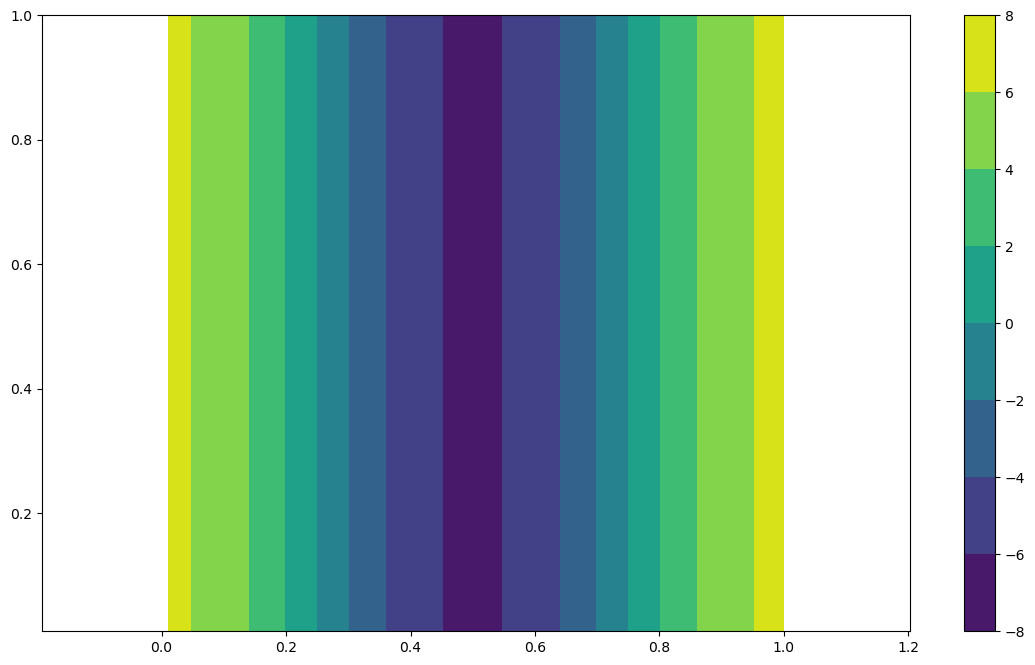

In [119]:
m = 99
h = 1 /(m+1)

x = (1:m+1) * h
println(size(x))
xx = reshape(repeat(x, m+1), (m+1, m+1))
yy = Matrix(xx')

divF = compact_div(sin.(2 * pi * xx), zeros(size(yy)), h)

clf()
contourf(xx, yy,  divF)
axis("equal")
colorbar()
gcf()

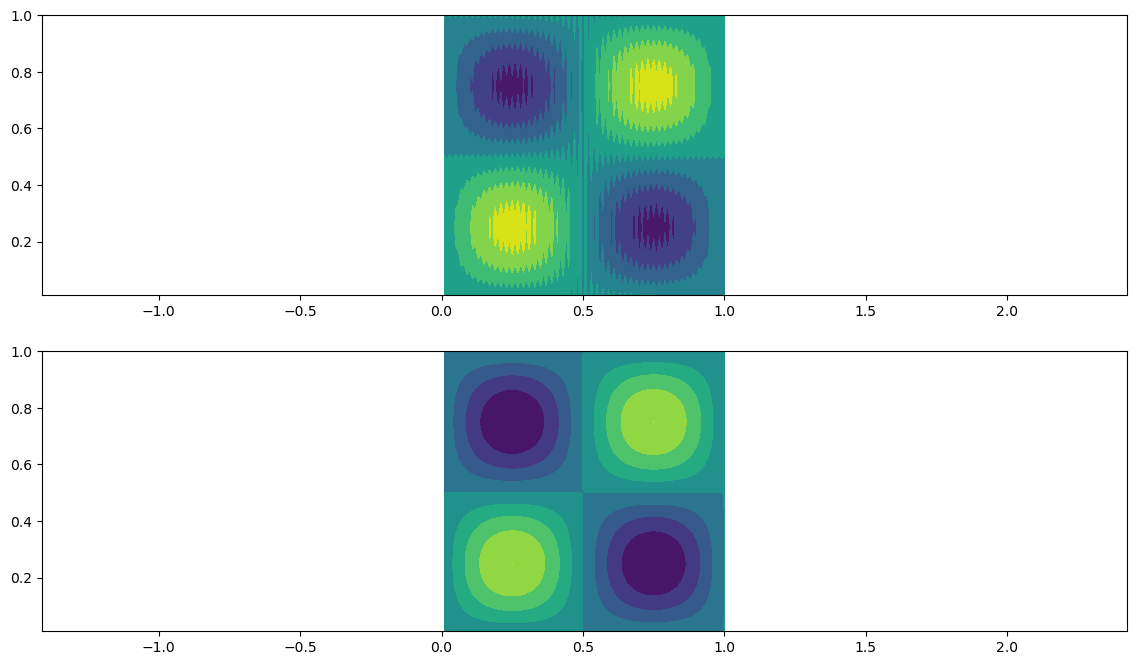

In [122]:
function compact_filter(u, alpha)
    a = 5/8 + 3*alpha/4
    b = alpha + 1/2
    c = alpha/4 - 1/8
    m = size(u)[1] - 1

    LHS = SymTridiagonal(ones(m+1), alpha * ones(m))
    LHS = sparse(LHS)
    LHS[1, end] = alpha
    LHS[end, 1] = alpha

    RHS = diagm(2 => c/2 * ones(m-1), 1 => b/2 * ones(m), 0 => a * ones(m+1), 
                -1 => b/2 * ones(m), -2 => c/2 * ones(m-1))

    RHS[1, end] = b/2
    RHS[1, end-1] = c/2
    RHS[2, end] = c/2
    RHS[end, 1] = b/2
    RHS[end, 2] = c/2
    RHS[end-1, 1] = c/2
    RHS = sparse(RHS)

    u = LHS \ (RHS * u)
    u = u'
    u = LHS \ (RHS * u)
    u = u'
    return u
end

m = 99
h = 1 /(m+1)
alpha = 0.25

x = (1:m+1) * h
xx = reshape(repeat(x, m+1), (m+1, m+1))
yy = Matrix(xx')


clf()
fig, ax = subplots(2, figsize = (14,8))

u = sin.(2 * pi * xx) * sin.(2 * pi * yy) + 10*sin.(m * pi * xx)

ax[1].contourf(xx, yy,  u)
ax[1].axis("equal")

uhat = compact_filter(u, alpha)
ax[2].contourf(xx, yy,  uhat)
ax[2].axis("equal")

gcf()

In [ ]:
Frx, Fry, Frux, Fruy, Frvx, Frvy, FrEx, FrEy =  euler_fluxes(r, ru, rv, rE)
divF = compact_div(Fx, Fy, h)

In [109]:
function euler_rhs(r, ru, rv, rE, h)
    Frx, Fry, Frux, Fruy, Frvx, Frvy, FrEx, FrEy =  euler_fluxes(r, ru, rv, rE)

    fr = compact_div(Frx, Fry, h)
    fru = compact_div(Frux, Fruy, h)
    frv = compact_div(Frvx, Frvy, h)
    frE = compact_div(FrEx, FrEy, h)
    
    return fr, fru, frv, frE 
end

euler_rhs (generic function with 1 method)

In [ ]:
function euler_rk4step(r, ru, rv, rE, h, k, alpha)
    fr, fru, frv, frE = euler_rhs(r, ru, rv, rE, h)
    

    return r, ru, rv, rE

In [110]:
function euler_vortex(x, y, time, pars)
    γ  = 1.4
    rc = pars[1]
    ϵ  = pars[2]
    M₀ = pars[3]
    θ  = pars[4]
    x₀ = pars[5]
    y₀ = pars[6]

    r∞ = 1
    u∞ = 1
    E∞ = 1/(γ*M₀^2*(γ - 1)) + 1/2
    p∞ = (γ - 1) * (E∞ - 1/2)
    ubar = u∞ * cos(θ)
    vbar = u∞ * sin(θ)
    f = @. (1 - ((x - x₀) - ubar*time)^2 - ((y - y₀) - vbar*time)^2) / rc^2

    u = @. u∞ * (cos(θ) - ϵ*((y - y₀)-vbar*time) / (2π*rc) * exp(f/2))
    v = @. u∞ * (sin(θ) + ϵ*((x - x₀)-ubar*time) / (2π*rc) * exp(f/2))
    r = @. r∞ * (1 - ϵ^2 * (γ - 1) * M₀^2/(8π^2) * exp(f))^(1/(γ-1))
    p = @. p∞ * (1 - ϵ^2 * (γ - 1) * M₀^2/(8π^2) * exp(f))^(γ/(γ-1))
    
    ru = @. r*u
    rv = @. r*v
    rE = @. p/(γ - 1) + 1/2 * (ru^2 + rv^2) / r
    
    r, ru, rv, rE
end

euler_vortex (generic function with 1 method)

In [117]:
N = 64
h = 10 / N
s = 0:h:10
x = repeat(s, 1, length(s))
y = Matrix(x')
pars = [0.5, 1, 0.5, pi/4, 2.5, 2.5]

r0, ru0, rv0, rE0 = euler_vortex(x, y, 5sqrt(2), pars)
r, ru, rv, rE = euler_vortex(x, y, 0, pars)

clf()
contourf(x, y, r)
axis("equal")
colorbar()
gcf()

UndefVarError: UndefVarError: `rr` not defined

In [ ]:

function validate_solver()
    pars = [0.5, 1, 0.5, pi/4, 2.5, 2.5]
    r, ru, rv, rE = euler_vortex(x, y, 0, pars)
    Ns = [32, 64, 128]
    for N = Ns
        h = 10 / N
